# Linear Dynamical Systems with MXNet

In this notebook we will look at how to implement filtering in general linear dynamical systems (aka Kalman filtering) using MXNet.

First, a short mathematical description of the problem. 

A general (Gaussian) linear dynamical system is specified by two equations. 

* The first, called the transition equation,

$$h_{t} = Ah_{t-1} + \epsilon_t \quad \quad \quad \epsilon_t \sim \mathcal{N}(0, \Sigma_h)$$

describes how the hidden (also called "latent") state $h_t \in \mathbb{R}^H$ evolves with time. In a LDS this involves applying a linear transformation $A \in \mathbb{R}^{H\times H}$ to the previous hidden state $h_{t-1}$, followed by adding zero-mean Gaussian noise. 

* The second, the observation equation or emission model, 

$$v_{t} = Bh_t + \nu_t \quad \quad \quad \nu_t \sim \mathcal{N}(0, \Sigma_v)$$

descibes how the latent state $h_t$ relates to the observations ("visibles") $v_t \in \mathbb{R}^D$. In particular, $v_t$ is a linear transformation of the hidden state, $Bh_t$, to which Gaussian noise is added.

Finally, we need to specify the initial state, usually by placing a Gaussian prior on $h_0$, 

$$h_0 \sim \mathcal{N}(\mu_0, \Sigma_0)$$

The LDS is thus fully specified by the system parameters 
$A \in \mathbb{R}^{H \times H}$, $B \in \mathbb{R}^{D \times H}$, $\Sigma_h \in \mathcal{S}_{+}^H$, $\Sigma_v \in \mathcal{S}_{+}^D$, $\mu_0 \in \mathbb{R}^H$, $\Sigma_0 \in \mathcal{S}_{+}^H$. $\mathcal{S}_{+}$ denotes the space of positive definite (PD) matrices.

Given such a LDS specification, and a sequence of observations $v_0, v_1, \ldots, v_T$, one is typically interested in one of the following

  1. (Log-)Likelihood computation, i.e. computing the probability of the data under the model, $P(v_0, v_1, \ldots, v_T)$
  2. Filtering, i.e. computing the mean and covariance of $P(h_t|v_0, v_1, \ldots, v_t)$
  3. Smoothing, i.e. computing the mean and covariance of $P(h_t|v_0, v_1, \ldots, v_T)$
  4. Parameter learning: find the system parameters that best describe the data, e.g. by maximizing likelihood
  
In this notebook we will focus on the filtering problem, and will also see how to compute the log-likelihood as a byproduct. For details on other problems, See e.g. [Barber, 2012](http://web4.cs.ucl.ac.uk/staff/D.Barber/textbook/020217.pdf), Chapter 24.

# Filtering
We want to find the "filtered" distributions $p(h_t|v_{0:t})$ where $v_{0:t}$ denotes $\{v_0, \cdots, v_t\}.$ Due to the closure properties of Gaussian distributions, each of these distributions is also Gaussian $p(h_t|v_{0:t}) = \mathcal{N}(h_t|f_t, F_T)$. The filtering procedure proceeds sequentially, by expressing $f_t$ and $F_t$ in terms of $f_{t-1}$ and $F_{t-1}$. We initialize $f_0$ and $F_0$ to be 0.

## Prerequisite

To derive the formulas for filtering, here is all you need [see Bishop 2008, Appendix B] 

* Conditional Gaussian equations

    $$
    \begin{split}
    p(x) &= \mathcal{N}(\mu, \Lambda^{-1})\\
    p(y|x) &= \mathcal{N}(y|Ax + b, L^{-1})
    \end{split}
    $$
    
    The marginal distribution of $y$ and the conditional distribution of $x$ given $y$ are
    
    $$
    \begin{split}
    p(y) &= \mathcal{N}(y|A\mu + b, L^{-1} + A\Lambda^{-1}A^T) &\quad \text{(1)} \\
    p(x|y) &= \mathcal{N}(x|\Sigma\left[A^TL(y-b) + \Lambda\mu\right], \Sigma), &\quad \Sigma = (\Lambda + A^TLA)^{-1}\quad \text{(2)}
    \end{split}
    $$
    
    
* Matrix Inversion Lemma (aka [Woodbury matrix identity](https://en.wikipedia.org/wiki/Woodbury_matrix_identity))

 $$ (A + BD^{-1}C)^{-1} = A^{-1} - A^{-1}B(D + CA^{-1}B)^{-1}CA^{-1}\quad \text{(3)}$$


## Derivation

Now we are ready to derive the filtering equations, by Bayes Theorem

$$
\begin{split}
p(h_t|v_{0:t}) &= p(h_t|v_t, v_{0:t-1}) \\
&\propto p(v_t|h_t, v_{0:t-1}) p(h_t|v_{0:t-1}) \\
&= p(v_t|h_t) p(h_t|v_{0:t-1})\quad \text{by Markov property}
\end{split}
$$

The derivation boils down to caclulate the two terms on the right hand side (you can think that the first is $p(y|x)$ and the second is $p(x)$ as in the conditional Gaussian equations) and use (2) above to get the desired formula. 

The first term is directly given by the observation equation, i.e., $p(v_t|h_t) = \mathcal{N}(Bh_t, \Sigma_v)$, and the second term can be calculated as follows

$$
\begin{split}
p(h_t|v_{0:t-1}) &= \int p(h_t|h_{t-1}, v_{0:t-1})p(h_{t-1}|v_{0:t-1}){\rm{d}}h_{t-1}\\
&= \int p(h_t|h_{t-1})p(h_{t-1}|v_{0:t-1}){\rm{d}}h_{t-1}\quad \text{by Markov property}\\
&= \int \mathcal{N}(h_t|Ah_{t-1}, \Sigma_h)\mathcal{N}(h_{t-1}|f_{t-1}, F_{t-1}){\rm{d}}h_{t-1}\\
&= \mathcal{N}(Af_{t-1}, AF_{t-1}A^T + \Sigma_h)\quad \text{using the marginalization equation (1)}\\
&= \mathcal{N}(\mu_f, \Sigma_{hh})\\
\end{split}
$$

First, we calculate the covariance matrix $F_t$, 

$$
F_t = \left(\Sigma_{hh}^{-1} - B^T\Sigma_v^{-1}B\right)^{-1} = \Sigma_{hh} - \Sigma_{hh}B^T(\Sigma_v + B\Sigma_{hh}B^T)^{-1}B\Sigma_{hh} = (I - KB)\Sigma_{hh}, 
$$

where we have used the matrix inversion lemman and define the **Kalman gain matrix** as

$$K = \Sigma_{hh}B^T(\Sigma_v + B\Sigma_{hh}B^T)^{-1}.$$ 

Notice that for numerical stability, the covariance matrix is normally calculated using so-called "Joseph's symmetrized update,"

$$F_t = (I - K_tB)\Sigma_{hh}(I-K_tB)^T +  K_t\Sigma_vK_t^T,$$

which consists of summing two PD matrices.


Finally, after some algebraic manipulation, we have the mean 

$$ f_t = \mu_{h} + K(v - B\mu_{h}).$$

## LDS Foward Pass

To summarize, the iterative algorithm proceeds as follows

$$\mu_h = Af_{t-1} \quad \quad \quad \mu_v = B\mu_h$$

$$\Sigma_{hh} = AF_{t-1}A^T + \Sigma_h \quad \quad \quad \Sigma_{vv} = B\Sigma_{hh}B^T + \Sigma_v$$

$$K_t = \Sigma_{hh}B^T\Sigma_{vv}^{-1}$$

$$f_t = \mu_h + K(v-\mu_v) \quad \quad \quad F_t = (I - K_tB)\Sigma_{hh}(I-K_tB)^T +  K_t\Sigma_vK_t^T$$

As we can see, each step in the recursive filtering procedure involves a few matrix-matrix and matrix-vector multiplications, as well as some matrix and vector additions and subtractions. These are standard operators available is most deep learning frameworks (including MXNet, where matrix multiplication is available through `mx.sym.dot()`).
However, the update also involves the term $\Sigma_{vv}^{-1}$, the inverse of a $D$-by-$D$ symmetric, postive semidefinite matrix (due to it being a covariance matrix). If the output dimensionality $D$ is 1, this is simply the scalar $1/\Sigma_{vv}$, but in the general case we need to compute the inverse (or, preferably, solve the corresponding linear system directly). 

Luckily, operators for doing exactly that have recently been added to MXNet. In particular, we have

  * `mx.nd.linalg_gemm2` (Matrix-matrix product, more flexible than `dot`)
  * `mx.nd.linalg_potrf` (Cholesky decomposition $A = LL^T$ for symmetric, PD matrix $A$)
  * `mx.nd.linalg_trsm` (solve system of equations involving triangular matrices)
  * `mx.nd.linalg_sumlogdiag` (compute the sum of the log of the diagonal elements of a matrix)
  * `mx.nd.linalg_potri` (compute $A^{-1}$ from a previously computed Cholesky factor $L$ of $A$ (i.e. $LL^T = A$).
  
## Computing the likelihood
The terms $\mu_v$ and $\Sigma_{vv}$ computed during the filtering update correspond to the mean and covariance of the predictive distribution $P(v_{t}|v_0, v_1, \ldots, v_{t-1})$, which allows us to compute the likelihood by decomposing it into telescoping conditional distributions, 

$$P(v_0, v_1, \ldots, v_t) = P(v_0)P(v_1|v_0)P(v_2|v_0, v_1)\cdots P(v_t|v_0, v_1, \ldots, v_{t-1})$$

and then using $P(v_t|v_0, v_1, \ldots, v_{t-1}) = \mathcal{N}(v_t|\mu_v, \Sigma_{vv})$ with parameters obtained during filtering to compute each term.

In [1]:
#load watermark
%load_ext watermark
%watermark -a 'Gopala KR' -u -d -v -p watermark,numpy,matplotlib,nltk,sklearn,tensorflow,theano,mxnet,chainer,seaborn,keras,tflearn,bokeh,gensim

/srv/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Using TensorFlow backend.
/srv/conda/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


Gopala KR 
last updated: 2018-03-01 

CPython 3.6.4
IPython 6.2.1

watermark 1.6.0
numpy 1.14.1
matplotlib 2.1.2
nltk 3.2.5
sklearn 0.19.1
tensorflow 1.5.0
theano 1.0.1
mxnet 1.2.0
chainer 3.4.0
seaborn 0.8.1
keras 2.1.4
tflearn n
bokeh 0.12.14
gensim 3.4.0


/srv/conda/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:20: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
import mxnet as mx

from mxnet.ndarray import linalg_gemm as gemm
from mxnet.ndarray import linalg_gemm2 as gemm2
from mxnet.ndarray import linalg_potrf as potrf
from mxnet.ndarray import linalg_trsm as trsm
from mxnet.ndarray import linalg_sumlogdiag as sumlogdiag

import mxnet.ndarray as nd

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 5)

# Generating Synthetic Dataset

This example is adapted from Example 24.3 in (Barber, 2017). The two-dimensional latent vector $h_t$ is rotated at each iteration and then is projected to produce a scalar observation. More precisely, we have

$$
h_{t+1} = Ah_{t} + \epsilon_h, \quad A = \begin{pmatrix}\cos\theta & -\sin\theta\\\sin\theta & \cos\theta\end{pmatrix}, \epsilon_h \sim \mathcal{N}(0, \alpha^2\cdot\mathbb{I}_2)
$$

$$
v_{t+1} = [1, 0]\cdot h_{t+1} + \epsilon_v, \quad , \epsilon_v \sim \mathcal{N}(0, \sigma^2).
$$

In [4]:
alpha = 0.5
sigma = 0.5
theta = np.pi / 6
T = 50

In [5]:
A = nd.array([[np.cos(theta), -np.sin(theta)],
              [np.sin(theta), np.cos(theta)]])
B = nd.array([[1, 0]])

S_h = nd.array(np.square(alpha) * np.eye(2))
S_v = nd.array(np.square(sigma) * np.eye(1))

v = []
# initial state h_0
h = np.array([1, 0])
for t in range(T):
    # h_t = Bh_{t-1} + \epsilon_h
    h = np.random.multivariate_normal(A.asnumpy().dot(h), S_h.asnumpy())
    
    # v_t = Ah_t + \epsilon_v
    vv = np.random.normal(B.asnumpy().dot(h), S_v.asnumpy())
    
    v.append(vv)
v = nd.array(np.array(v).reshape((T,1)))

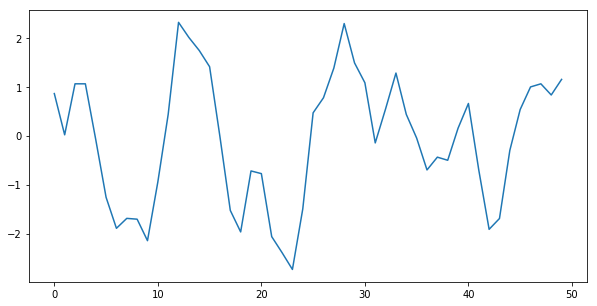

In [6]:
plt.plot(v.asnumpy());

## LDS Forward Function (Filtering)

In [7]:
def LDS_forward(v, A, B, S_h, S_v):
    
    H = A.shape[0] # dim of latent state
    D = B.shape[0] # dim of observation
    T = v.shape[0] # num of observations
    
    f_0 = nd.zeros((H,1))
    F_0 = nd.zeros((H,H))
    
    eye_h = nd.array(np.eye(H))    
    
    F_t = None
    f_t = None
    F_seq = []
    f_seq = []
    log_p_seq = []

    for t in range(T):

        if t == 0:
            # At the first time step, use the prior
            mu_h = f_0
            S_hh = F_0
        else:
            # Otherwise compute using update eqns.
            mu_h = gemm2(A, f_t)
            S_hh = gemm2(A, gemm2(F_t, A, transpose_b=1)) + S_h

        # direct transcription of the update equations above
        mu_v = gemm2(B, mu_h)
        S_hh_x_B_t = gemm2(S_hh, B, transpose_b=1)
        S_vv = gemm2(B, S_hh_x_B_t) + S_v
        S_vh = gemm2(B, S_hh)

        # use potrf to compute the Cholesky decomposition S_vv = LL^T
        S_vv_chol = potrf(S_vv)

        # K = S_hh X with X = B^T S_vv^{-1}
        # We have X = B^T S_vv^{-1} => X S_vv = B^T => X LL^T = B^T
        # We can thus obtain X by solving two linear systems involving L
        K = trsm(S_vv_chol, trsm(S_vv_chol, S_hh_x_B_t, rightside=1, transpose=1), rightside=1)

        delta = v[t] - mu_v
        f_t = mu_h + gemm2(K, delta)

        ImKB = eye_h - gemm2(K, B)
        F_t = (gemm2(ImKB, gemm2(S_hh, ImKB, transpose_b=True)) 
                       + gemm2(K, gemm2(S_v, K, transpose_b=True), name="Ft"))

        # save filtered covariance and mean
        F_seq.append(F_t)
        f_seq.append(f_t)
        
        # compute the likelihood using mu_v and L (LL^T = S_vv)
        Z = trsm(S_vv_chol, trsm(S_vv_chol, delta), transpose=1)
        log_p = (-0.5 * (mx.nd.reshape(gemm2(delta, Z, transpose_a=True), shape=(0,), name="reshaped") 
                         + D*np.log(2.0 * np.pi)) - sumlogdiag(S_vv_chol))
        log_p_seq.append(log_p)
        
    
    return f_seq, F_seq, log_p_seq

In [8]:
f_seq, F_seq, _ = LDS_forward(v, A, B, S_h, S_v)

## Calculate the filtered mean and variance 


Given $p(h_t|v_{0:t})=\mathcal{N}(\mu_t, \Sigma_t)$, we can compute the distribution of the reconstructed observations 

$$
p(\widehat{v_t}) = \mathcal{N}(B\mu_t, B\Sigma_tB^T + \sigma^2).
$$

In [9]:
from functools import reduce
B_np = B.asnumpy()
h_states = reduce(lambda x, y: np.hstack((x,y)), [ff.asnumpy() for ff in f_seq])
v_filtered_mean = B.asnumpy().dot(h_states).reshape((T,))

In [10]:
v_filtered_var = np.sqrt(
    np.array([B_np.dot(ff.asnumpy()).dot(B_np.T) + np.square(sigma) for ff in F_seq]).reshape((T,)))

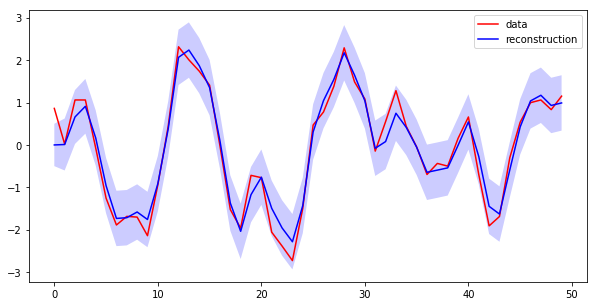

In [11]:
plt.plot(v.asnumpy(), color="r")
plt.plot(v_filtered_mean, color="b")
x = np.arange(T)
plt.fill_between(x, v_filtered_mean-v_filtered_var, 
                 v_filtered_mean+v_filtered_var, 
                 facecolor="blue", alpha=0.2)
plt.legend(["data", "reconstruction"]);

In the next notebook, we will use Kalman filtering as a subroutine in more complex models. In particular, we will show how to do time series forecasting with innovative state space models (ISSMs). 